# Modeling and Evaluation 

In [1]:
# hide warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# import libraries
import numpy as np
import pandas as pd

import statistics
import matplotlib.pyplot as plt
%matplotlib inline
import pylab as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,precision_score, recall_score, f1_score, log_loss
from sklearn.svm import SVC 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
import six
import sys
sys.modules['sklearn.externals.six']=six
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO
from IPython.display import Image
import pydotplus
from sklearn.tree import export_text

In [3]:
# loading data
df = pd.read_csv("modeling.csv")
df.head()

,sbp,tobacco,ldl,adiposity,famhist,typea,alcohol,age,chd
0,160.0,12.00,5.73,23.11,1,49.0,59.16,52,1
1,144.0,0.01,4.41,28.61,0,55.0,2.06,63,1
2,118.0,0.08,3.48,32.28,1,52.0,3.81,46,0
3,170.0,7.50,6.41,38.03,1,51.0,24.26,58,1
4,134.0,13.60,3.50,27.78,1,60.0,57.34,49,1


In [4]:
X_before = df.iloc[:, 0:8]
y = df["chd"]

scaler = MinMaxScaler()
X = pd.DataFrame(scaler.fit_transform(X_before.values), 
                         columns=X_before.columns, index=X_before.index)
X.head()

,sbp,tobacco,ldl,adiposity,famhist,typea,alcohol,age
0,0.710843,0.877754,0.554178,0.457902,1.0,0.425743,1.000000,0.755102
1,0.518072,0.000731,0.400175,0.611748,0.0,0.544554,0.034821,0.979592
2,0.204819,0.005852,0.291673,0.714406,1.0,0.485149,0.064402,0.632653
3,0.831325,0.548597,0.633513,0.875245,1.0,0.465347,0.410074,0.877551
4,0.397590,0.994788,0.294006,0.588531,1.0,0.643564,0.969236,0.693878


In [5]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)

# Modeling

### 1. Support Vector Machines

#### 1.1. Hypertuning model parameters using GridSearchCV

In [6]:
param_grid = {'C': [1,0.1,10], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid'], 'degree': [2,3,4,5,6,7,8]}
grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=True)
grid.fit(X_train,y_train)

Fitting 5 folds for each of 252 candidates, totalling 1260 fits


GridSearchCV(estimator=SVC(),
             param_grid={'C': [1, 0.1, 10], 'degree': [2, 3, 4, 5, 6, 7, 8],
                         'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['rbf', 'poly', 'sigmoid']},
             verbose=True)

In [7]:
print(grid.best_estimator_)
print(grid.best_params_)

SVC(C=1, degree=7, gamma=1, kernel='poly')
{'C': 1, 'degree': 7, 'gamma': 1, 'kernel': 'poly'}


#### 1.2. Building SVM Classifier

In [8]:
#create new a SVM model
model = SVC(kernel='poly', C=1, degree=7, gamma=1, probability=True)

# Fit the classifier to the data
model.fit(X_train,y_train)
svm_pred = model.predict(X_test)

#### 1.3. Assess Model 

In [9]:
cr = classification_report(y_test, svm_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.84      0.79      0.81        89
           1       0.81      0.86      0.83        93

    accuracy                           0.82       182
   macro avg       0.83      0.82      0.82       182
weighted avg       0.83      0.82      0.82       182



In [10]:
cf_matrix = confusion_matrix(y_test,svm_pred, labels=[1,0])
print(cf_matrix)

[[80 13]
 [19 70]]


In [11]:
tn, fp, fn, tp = confusion_matrix(y_test,svm_pred, labels=[0, 1]).ravel()

print('True Positive', tp)
print('True Negative', tn)
print('False Positive', fp)
print('False Negative', fn)

True Positive 80
True Negative 70
False Positive 19
False Negative 13


In [12]:
total1=sum(sum(cf_matrix))
#####from confusion matrix calculate accuracy
accuracy1=(cf_matrix[0,0]+cf_matrix[1,1])/total1
print ('Accuracy : ', accuracy1)

sensitivity1 = cf_matrix[0,0]/(cf_matrix[0,0]+cf_matrix[0,1])
print('Sensitivity : ', sensitivity1 )

specificity1 = cf_matrix[1,1]/(cf_matrix[1,0]+cf_matrix[1,1])
print('Specificity : ', specificity1)

Accuracy :  0.8241758241758241
Sensitivity :  0.8602150537634409
Specificity :  0.7865168539325843


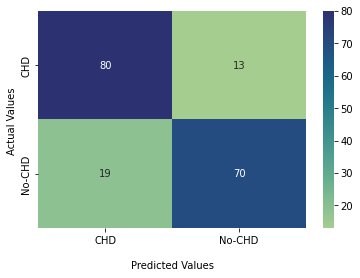

In [13]:
ax = sns.heatmap(cf_matrix, annot=True, cmap='crest')

ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['CHD','No-CHD'])
ax.yaxis.set_ticklabels(['CHD','No-CHD'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [14]:
# worset case, when the model predict all wrong
r_probs = [0 for _ in range(len(y_test))]
# predict probabilities
svm_probs = model.predict_proba(X_test)
# keep probabilities for the positive outcome only
svm_probs = svm_probs[:, 1]

In [15]:
# calculate scores
r_auc = roc_auc_score(y_test, r_probs)
print(r_auc)
svm_auc = roc_auc_score(y_test, svm_probs)
print(svm_auc)

0.5
0.824332487616286


In [16]:
# calculate roc curves
r_fpr, r_tpr, _ = roc_curve(y_test, r_probs)
svm_fpr, svm_tpr, _ = roc_curve(y_test, svm_probs)

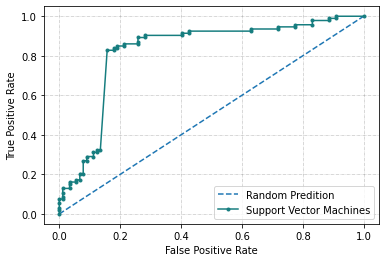

In [17]:
# plot the roc curve for the model
plt.grid(b = True, color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.6)
plt.plot(r_fpr, r_tpr, linestyle='--', label='Random Predition',)
plt.plot(svm_fpr, svm_tpr, marker='.', label='Support Vector Machines', color='#167D7F')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

### 2. Decision Tree

#### 2.1. Hypertuning model parameters using GridSearchCV

In [18]:
tuned_parameters = [{'criterion': ['gini','entropy'],'max_depth': [1,2,3,4,5,6], 
                     'min_samples_split': [2,4,6,8]}]
scores = ['recall']
for score in scores:
    
    print()
    print(f"Tuning hyperparameters for {score}")
    print()
    
    grid = GridSearchCV(
        DecisionTreeClassifier(), tuned_parameters,
        scoring = f'{score}_macro'
    )
    grid.fit(X_train, y_train)
    
    print("Best parameters set found on development set:")
    print()
    print(grid.best_params_)
    print()


Tuning hyperparameters for recall

Best parameters set found on development set:

{'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 4}



#### 2.2. Build Classifier 

In [19]:
# create Decision Tree Model
model = DecisionTreeClassifier(criterion = 'gini', max_depth =4,min_samples_split=2)
# Fit the classifier to the data
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [20]:
# importance feature
importance = pd.DataFrame({'feature': X_train.columns, 
'importance' : np.round(model.feature_importances_, 3)})
importance.sort_values('importance', ascending=False, inplace = True)
print(importance)

     feature  importance
7        age       0.518
1    tobacco       0.134
2        ldl       0.111
4    famhist       0.091
6    alcohol       0.076
5      typea       0.070
0        sbp       0.000
3  adiposity       0.000


#### 2.3. Assess the model

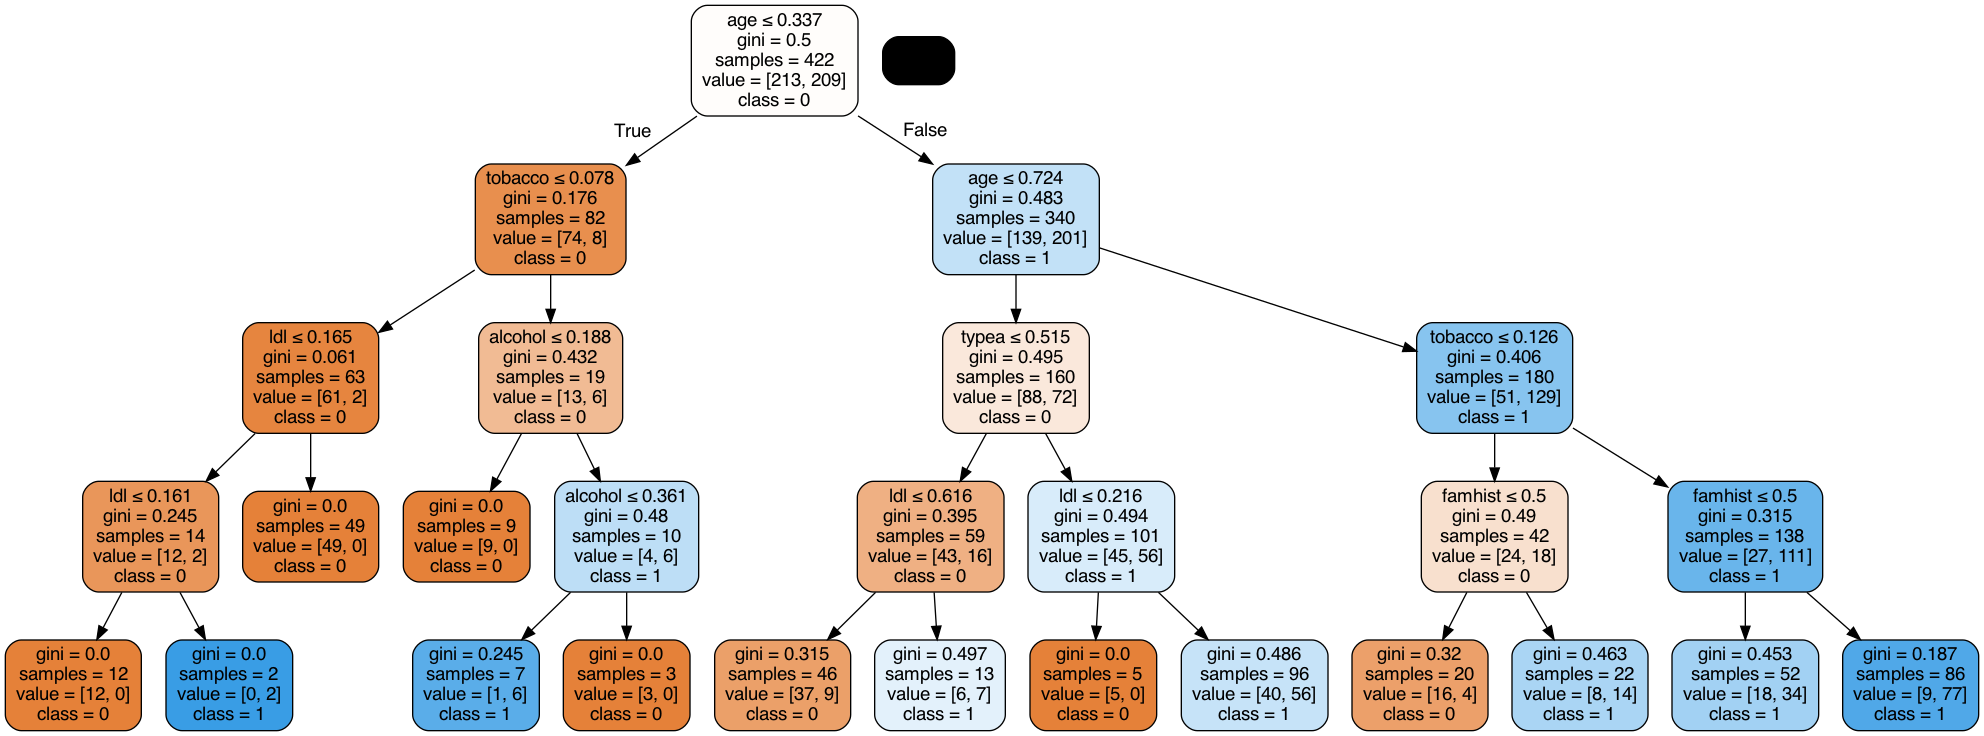

In [21]:
dot_data = StringIO()
export_graphviz(model, out_file=dot_data,
               filled= True, rounded=True,
               special_characters= True, feature_names= X.columns,class_names =['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png('DecisionTreeModel.png')
Image(graph.create_png())

In [22]:
feature_names = X.columns
tree_rules = export_text(model,
                        feature_names = list(X))

print(tree_rules)

|--- age <= 0.34
|   |--- tobacco <= 0.08
|   |   |--- ldl <= 0.17
|   |   |   |--- ldl <= 0.16
|   |   |   |   |--- class: 0
|   |   |   |--- ldl >  0.16
|   |   |   |   |--- class: 1
|   |   |--- ldl >  0.17
|   |   |   |--- class: 0
|   |--- tobacco >  0.08
|   |   |--- alcohol <= 0.19
|   |   |   |--- class: 0
|   |   |--- alcohol >  0.19
|   |   |   |--- alcohol <= 0.36
|   |   |   |   |--- class: 1
|   |   |   |--- alcohol >  0.36
|   |   |   |   |--- class: 0
|--- age >  0.34
|   |--- age <= 0.72
|   |   |--- typea <= 0.51
|   |   |   |--- ldl <= 0.62
|   |   |   |   |--- class: 0
|   |   |   |--- ldl >  0.62
|   |   |   |   |--- class: 1
|   |   |--- typea >  0.51
|   |   |   |--- ldl <= 0.22
|   |   |   |   |--- class: 0
|   |   |   |--- ldl >  0.22
|   |   |   |   |--- class: 1
|   |--- age >  0.72
|   |   |--- tobacco <= 0.13
|   |   |   |--- famhist <= 0.50
|   |   |   |   |--- class: 0
|   |   |   |--- famhist >  0.50
|   |   |   |   |--- class: 1
|   |   |--- tobacco >  0

In [23]:
cr = classification_report(y_test, y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.86      0.63      0.73        89
           1       0.72      0.90      0.80        93

    accuracy                           0.77       182
   macro avg       0.79      0.77      0.76       182
weighted avg       0.79      0.77      0.76       182



In [24]:
cf_matrix = confusion_matrix(y_test,y_pred, labels=[1,0])
print(cf_matrix)

[[84  9]
 [33 56]]


In [25]:
tn, fp, fn, tp = confusion_matrix(y_test,y_pred, labels=[0, 1]).ravel()

print('True Positive', tp)
print('True Negative', tn)
print('False Positive', fp)
print('False Negative', fn)

True Positive 84
True Negative 56
False Positive 33
False Negative 9


In [26]:
total1=sum(sum(cf_matrix))
#####from confusion matrix calculate accuracy
accuracy1=(cf_matrix[0,0]+cf_matrix[1,1])/total1
print ('Accuracy : ', accuracy1)

sensitivity1 = cf_matrix[0,0]/(cf_matrix[0,0]+cf_matrix[0,1])
print('Sensitivity : ', sensitivity1 )

specificity1 = cf_matrix[1,1]/(cf_matrix[1,0]+cf_matrix[1,1])
print('Specificity : ', specificity1)

Accuracy :  0.7692307692307693
Sensitivity :  0.9032258064516129
Specificity :  0.6292134831460674


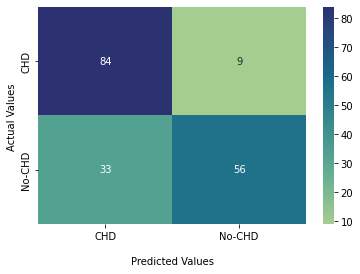

In [27]:
ax = sns.heatmap(cf_matrix, annot=True, cmap='crest')

ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['CHD','No-CHD'])
ax.yaxis.set_ticklabels(['CHD','No-CHD'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [28]:
# predict probabilities
tree_probs = model.predict_proba(X_test)
# keep probabilities for the positive outcome only
tree_probs = tree_probs[:, 1]
tree_auc = roc_auc_score(y_test, tree_probs)
print(tree_auc)

0.8071161048689138


In [29]:
r_fpr, r_tpr, _ = roc_curve(y_test, r_probs)
tree_fpr, tree_tpr, _ = roc_curve(y_test, tree_probs)

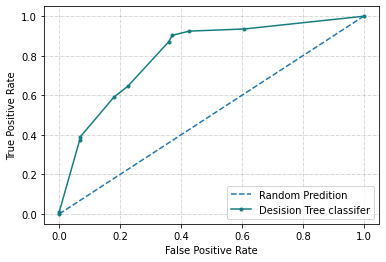

In [30]:
# plot the roc curve for the model
plt.grid(b = True, color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.6)
plt.plot(r_fpr, r_tpr, linestyle='--', label='Random Predition',)
plt.plot(tree_fpr, tree_tpr, marker='.', label='Desision Tree classifer', color='#167D7F')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

### 3. Logistic Regression

#### 3.1. Hypertuning model parameters using GridSearchCV

In [31]:
parameters = {'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
    'C' : np.logspace(-4, 4, 20),
    'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter' : [100, 1000,2500, 5000]
    }
clf = GridSearchCV(LogisticRegression(), param_grid = parameters, verbose=True)
clf.fit(X_train,y_train)

Fitting 5 folds for each of 1600 candidates, totalling 8000 fits


GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                         'max_iter': [100, 1000, 2500, 5000],
                         'penalty': ['l1', 'l2', 'elasticnet', 'none'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']},
             verbose=True)

In [32]:
print("Tuned Hyperparameters :", clf.best_params_)
print("Best Estimator :",clf.best_estimator_)

Tuned Hyperparameters : {'C': 0.23357214690901212, 'max_iter': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
Best Estimator : LogisticRegression(C=0.23357214690901212, solver='newton-cg')


#### 3.2. Building Logistic Regression Classifier

In [33]:
# build the model
log_reg = LogisticRegression(solver='newton-cg', penalty='l2', C=0.23357214690901212, max_iter=100)

# fit the model with data
log_reg.fit(X_train,y_train)

# predict the testing set
log_pred = log_reg.predict(X_test)

In [34]:
print('intercept ', log_reg.intercept_[0])
print('classes', log_reg.classes_)
pd.DataFrame({'coeff': log_reg.coef_[0]}, 
             index=X.columns)


intercept  -2.251568648251529
classes [0 1]


,coeff
sbp,0.224334
tobacco,0.988312
ldl,0.606026
adiposity,0.105982
famhist,0.842028
typea,0.362228
alcohol,0.072231
age,1.470739


#### 3.3. Assess Model

In [35]:
cnf_matrix = confusion_matrix(y_test, log_pred, labels=[1,0])
cnf_matrix

array([[74, 19],
       [29, 60]])

In [36]:
tn, fp, fn, tp = confusion_matrix(y_test,log_pred, labels=[0, 1]).ravel()

print('True Positive', tp)
print('True Negative', tn)
print('False Positive', fp)
print('False Negative', fn)

True Positive 74
True Negative 60
False Positive 29
False Negative 19


In [37]:
total1=sum(sum(cnf_matrix))
#####from confusion matrix calculate accuracy
accuracy1=(cnf_matrix[0,0]+cnf_matrix[1,1])/total1
print ('Accuracy : ', accuracy1)

sensitivity1 = cnf_matrix[0,0]/(cnf_matrix[0,0]+cnf_matrix[0,1])
print('Sensitivity : ', sensitivity1 )

specificity1 = cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1])
print('Specificity : ', specificity1)

Accuracy :  0.7362637362637363
Sensitivity :  0.7956989247311828
Specificity :  0.6741573033707865


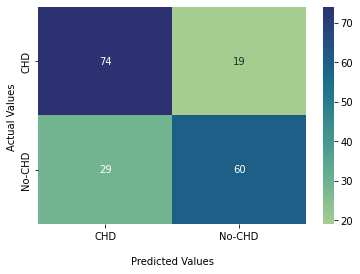

In [38]:
ax = sns.heatmap(cnf_matrix, annot=True, cmap='crest')

ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['CHD','No-CHD'])
ax.yaxis.set_ticklabels(['CHD','No-CHD'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [39]:
cr_lo = classification_report(y_test, log_pred)
print(cr_lo)

              precision    recall  f1-score   support

           0       0.76      0.67      0.71        89
           1       0.72      0.80      0.76        93

    accuracy                           0.74       182
   macro avg       0.74      0.73      0.73       182
weighted avg       0.74      0.74      0.74       182



0.5
0.8150296000966534


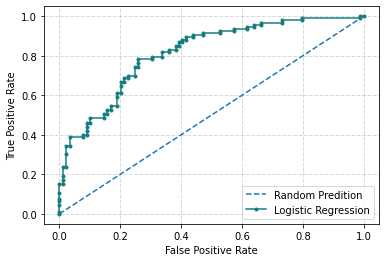

In [40]:
p_probs = log_reg.predict_proba(X_test)
r_probs = [0 for _ in range(len(y_test))]

p_probs = p_probs[:, 1]

r_auc = roc_auc_score(y_test, r_probs)
print(r_auc)
logreg_auc = roc_auc_score(y_test, p_probs)
print(logreg_auc)


r_fpr, r_tpr, _ = roc_curve(y_test, r_probs)
logreg_fpr, logreg_tpr, _ = roc_curve(y_test, p_probs)

# plot the roc curve for the model
plt.grid(b = True, color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.6)
plt.plot(r_fpr, r_tpr, linestyle='--', label='Random Predition',)
plt.plot(logreg_fpr, logreg_tpr, marker='.', label='Logistic Regression', color='#167D7F')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

In [41]:
log_loss(y_test, p_probs)

0.543281570543671

# Evalution

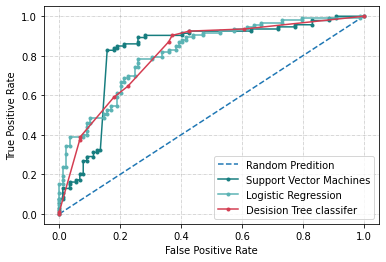

In [42]:
# plot the roc curve for the model
plt.grid(b = True, color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.6)
plt.plot(r_fpr, r_tpr, linestyle='--', label='Random Predition')
plt.plot(svm_fpr, svm_tpr, marker='.', label='Support Vector Machines', color='#167D7F')
plt.plot(logreg_fpr, logreg_tpr, marker='.', label='Logistic Regression', color='#5ab3b4')
plt.plot(tree_fpr, tree_tpr, marker='.', label='Desision Tree classifer', color='#d43d51')

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()